In [3]:
import json, requests, csv, time, operator
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as ticker
import ast
import seaborn as sns
import time
import datetime
from sklearn.gaussian_process import GaussianProcess

# Split the output file into csv with columns

In [2]:
with open('output_file.csv', 'r',encoding="utf8") as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=';')
    next(csv_reader)
    
    file_to_write = open('split_file.csv', 'w',encoding="utf8", newline='')
    csv_writer = csv.writer(file_to_write,delimiter=';')
    headers=['id','imdb_id','title','original_language','adult','collection','runtime',
            'popularity','vote_average','vote_count','release_date','budget','revenue',
            'release_dates','genres','production_companies','production_countries','cast','crew','keywords']
    csv_writer.writerow(headers)
    
    for row in csv_reader:
        row_to_write=[]
        json_data=json.loads(row[1])
        if('status_code' in json_data):
            continue
        row_to_write.append(json_data['id'])
        row_to_write.append(json_data['imdb_id'])
        row_to_write.append(json_data['title'])
        row_to_write.append(json_data['original_language'])
        row_to_write.append(json_data['adult'])
        
        if json_data['belongs_to_collection'] is not None:
            row_to_write.append(json_data['belongs_to_collection']['id'])
        else:
            row_to_write.append(None)
            
        row_to_write.append(json_data['runtime'])
        row_to_write.append(json_data['popularity'])
        row_to_write.append(json_data['vote_average'])
        row_to_write.append(json_data['vote_count'])
        row_to_write.append(json_data['release_date'])
        row_to_write.append(json_data['budget'])
        row_to_write.append(json_data['revenue'])
        
        release_dates=json_data['release_dates']['results']
        for release_language in release_dates:
            for single_release in release_language['release_dates']:
                del single_release['certification']
                del single_release['iso_639_1']
                if 'note' in single_release:
                    del single_release['note']
        row_to_write.append(release_dates)
        
        genres=json_data['genres']
       # for genre in genres:
       #     del genre['name']
        row_to_write.append(genres)
            
        companies=json_data['production_companies']
        #for company in companies:
        #    del company['name']
        row_to_write.append(companies)
        
        countries=json_data['production_countries']
        #for country in countries:
        #    del country['name']
        row_to_write.append(countries)
        
        cast=json_data['credits']['cast']
        for actor in cast:
            del actor['cast_id']
            del actor['character']
            del actor['credit_id']
          #  del actor['name']
            del actor['order']
            del actor['profile_path']
        row_to_write.append(cast)
        
        crew=json_data['credits']['crew']
        for crewman in crew:
            del crewman['credit_id']
          #  del crewman['name']
            del crewman['profile_path']
        row_to_write.append(crew)
        
        row_to_write.append(json_data['keywords']['keywords'])
        
        csv_writer.writerow(row_to_write)
   
    file_to_write.close()

# Read data into dataframe

In [4]:
test_data=pd.read_csv('split_file.csv',delimiter=';')

# Scatterplot by genres

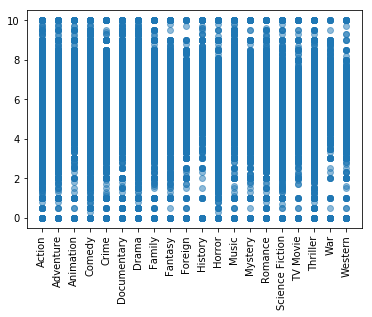

In [4]:
x_genre=[]
y_score=[]

for index, row in test_data.iterrows():
    row_genres=ast.literal_eval(row['genres'])
    for genre in row_genres:
        x_genre.append(genre['name'])
        y_score.append(row['vote_average'])      
plt.scatter(x_genre, y_score, alpha=0.5)
plt.xticks(rotation=90)
plt.show()

# Violinplot by genres

With votes: 49961
With vote count 0: 58835


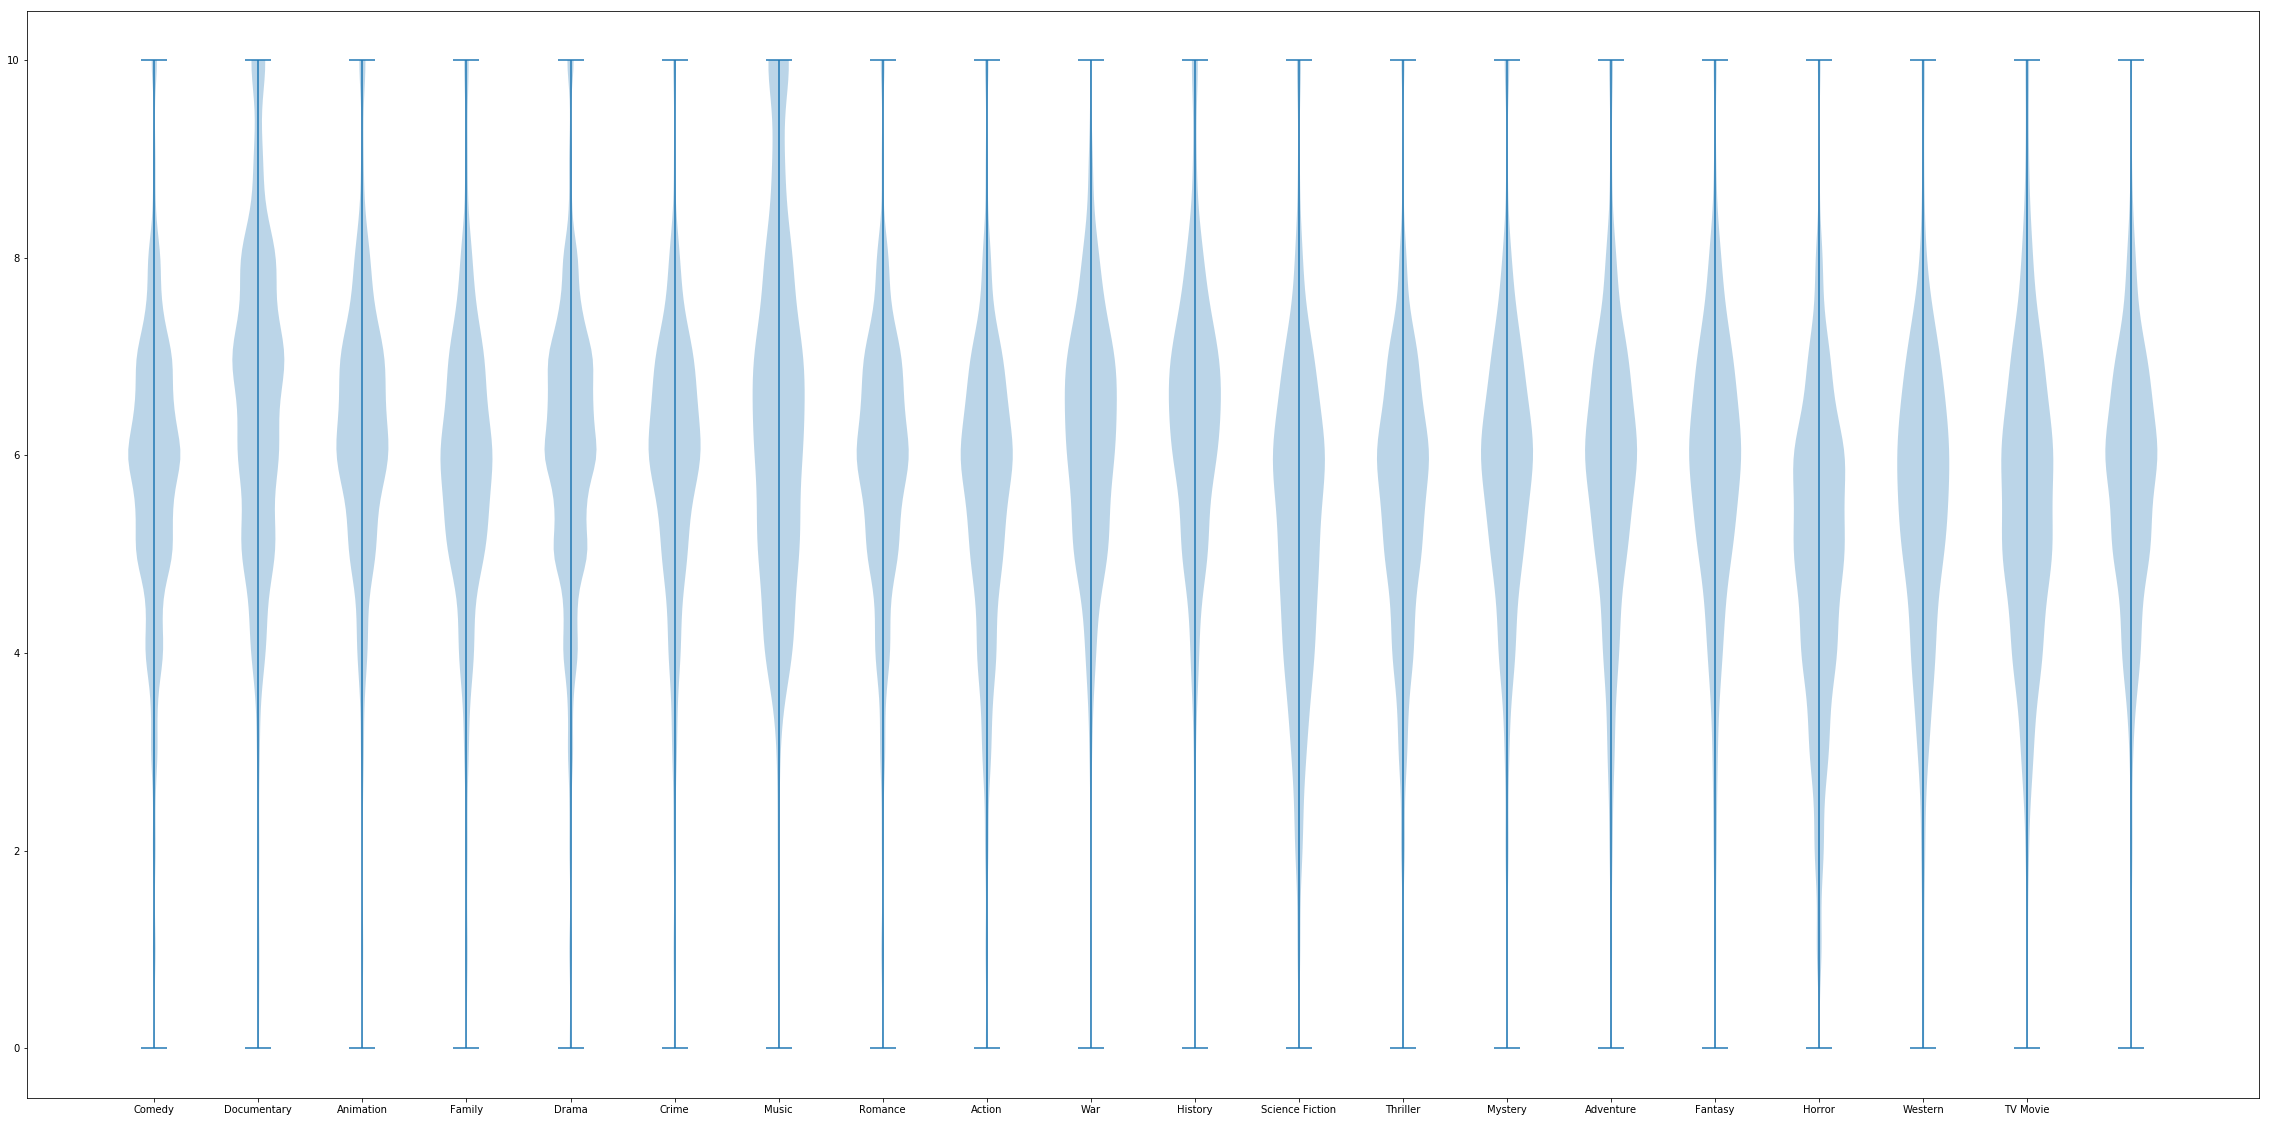

In [5]:
genres_dict={}
zero_votes=0
with_votes=0
for index, row in test_data.iterrows():
    row_genres=ast.literal_eval(row['genres'])
    if(row['vote_count']==0):
            zero_votes=zero_votes+1
            continue
    for genre in row_genres:
        if genre['name'] not in genres_dict:
            genres_dict[genre['name']]=[]
        genres_dict[genre['name']].append(row['vote_average'])
    with_votes=with_votes+1
labels= genres_dict.keys()
data=genres_dict.values()

print("With votes: "+str(with_votes))
print("With vote count 0: "+str(zero_votes))

plt.figure( figsize=(40, 20))
pos=list(range(1, 20))
ax = plt.subplot(111)
plt.violinplot(data)
ax.set_xticks(pos)
ax.set_xticklabels(labels)
plt.show()

# Boxplot by genres

Average value: 5.675286723644443


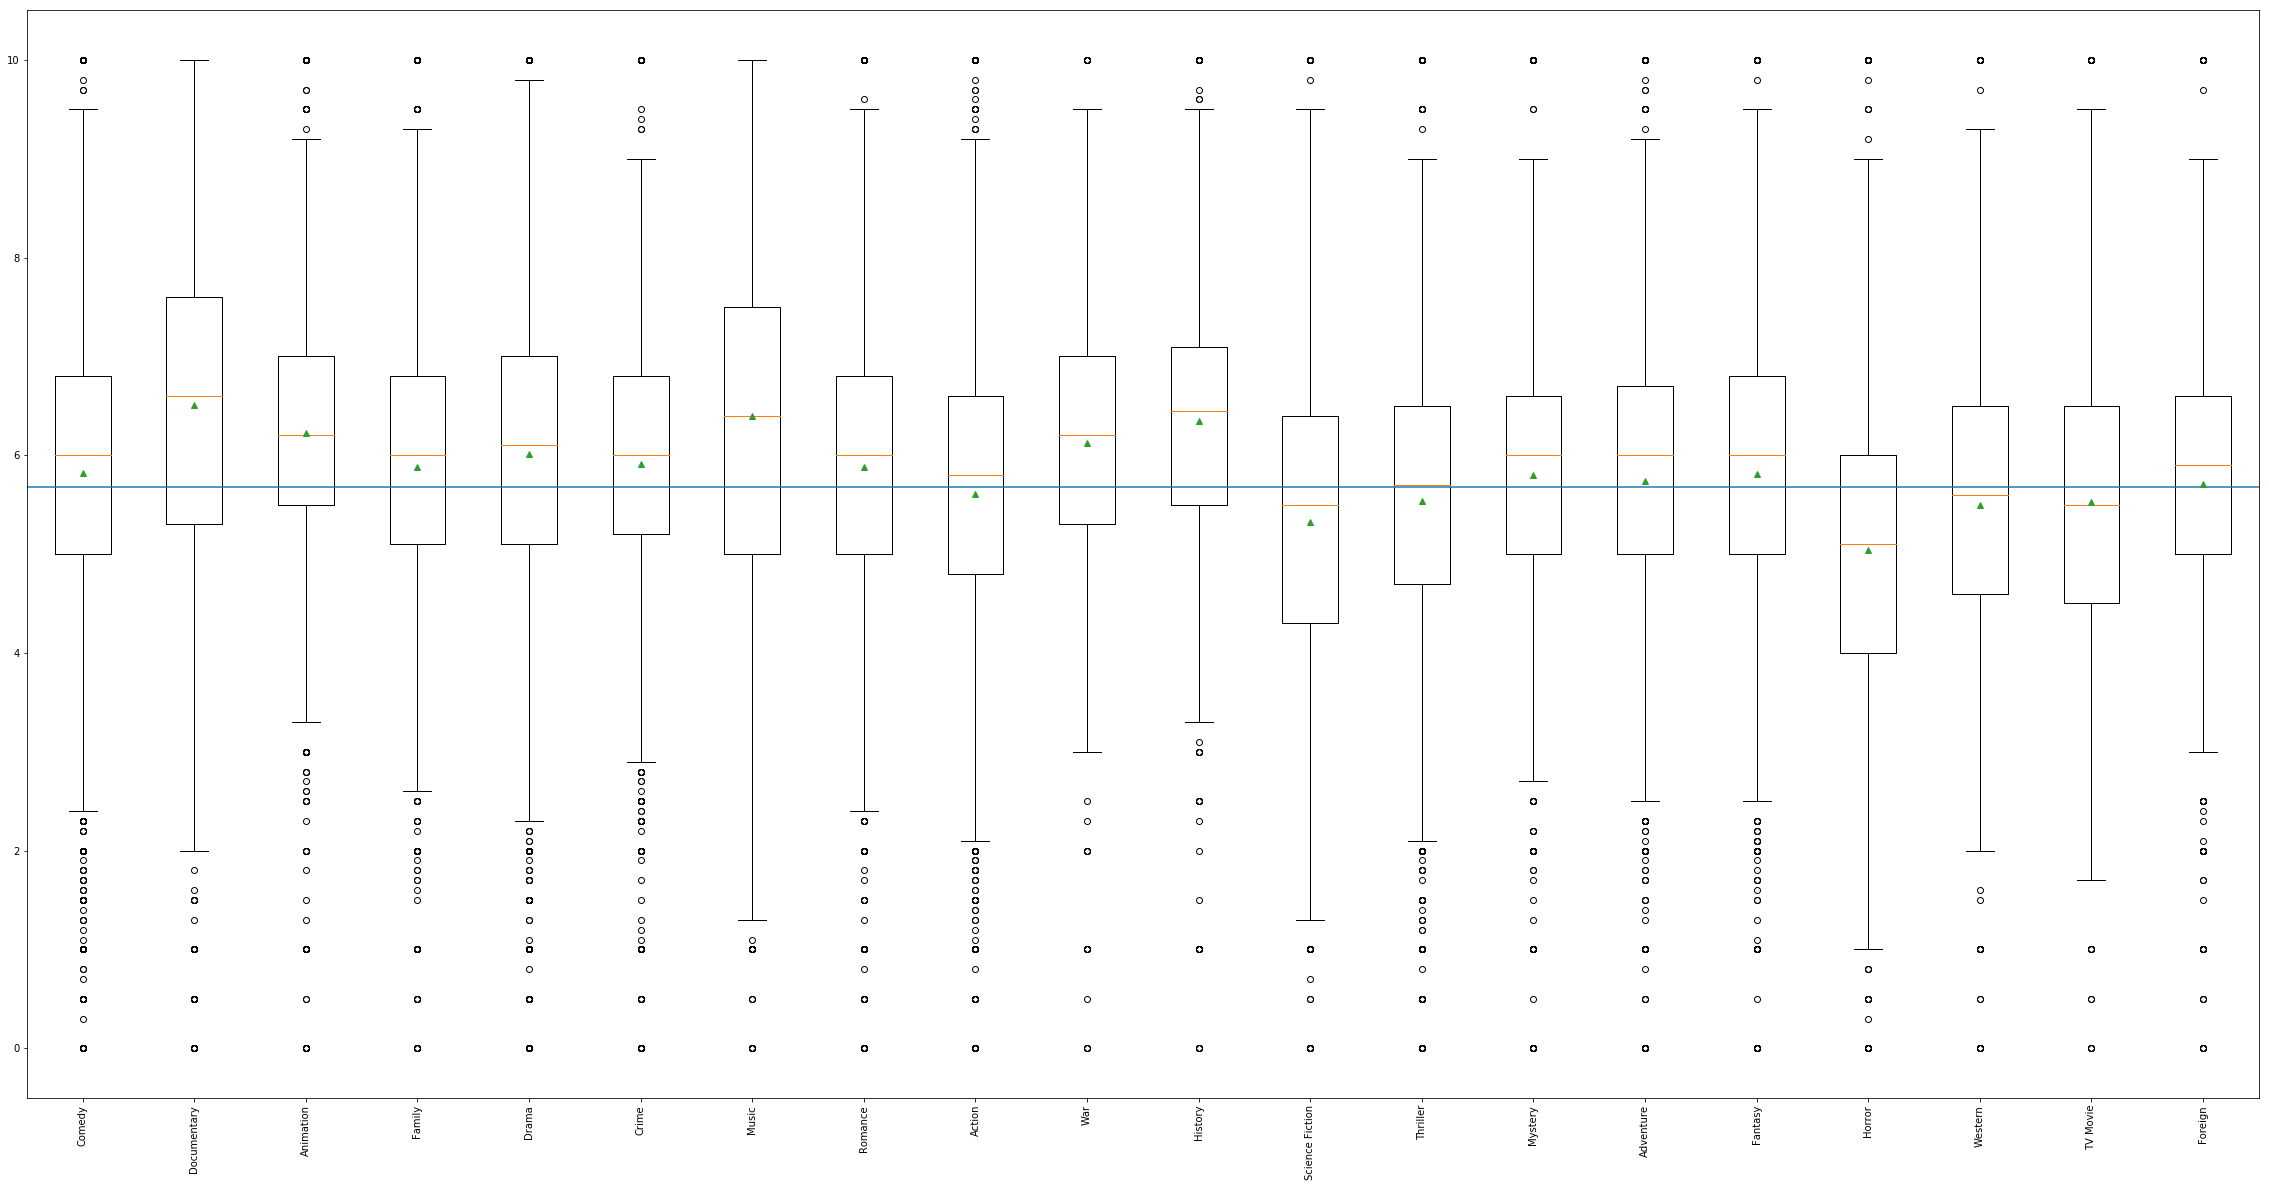

In [6]:
genres_dict={}
vote_sum=0
vote_count=0
for index, row in test_data.iterrows():
    row_genres=ast.literal_eval(row['genres'])
    if(row['vote_count']==0):
        continue
    for genre in row_genres:
        if genre['name'] not in genres_dict:
            genres_dict[genre['name']]=[]
        genres_dict[genre['name']].append(row['vote_average'])
    vote_sum=vote_sum+int(row['vote_average'])
    vote_count=vote_count+1
labels= genres_dict.keys()
data=genres_dict.values()

avg=vote_sum/vote_count
print("Average value: "+str(avg))

plt.figure( figsize=(40, 20))
plt.boxplot(data,labels=labels,showmeans=True)
plt.xticks(rotation=90)
plt.axhline(y=avg)
plt.show()

# Barchart of each genre

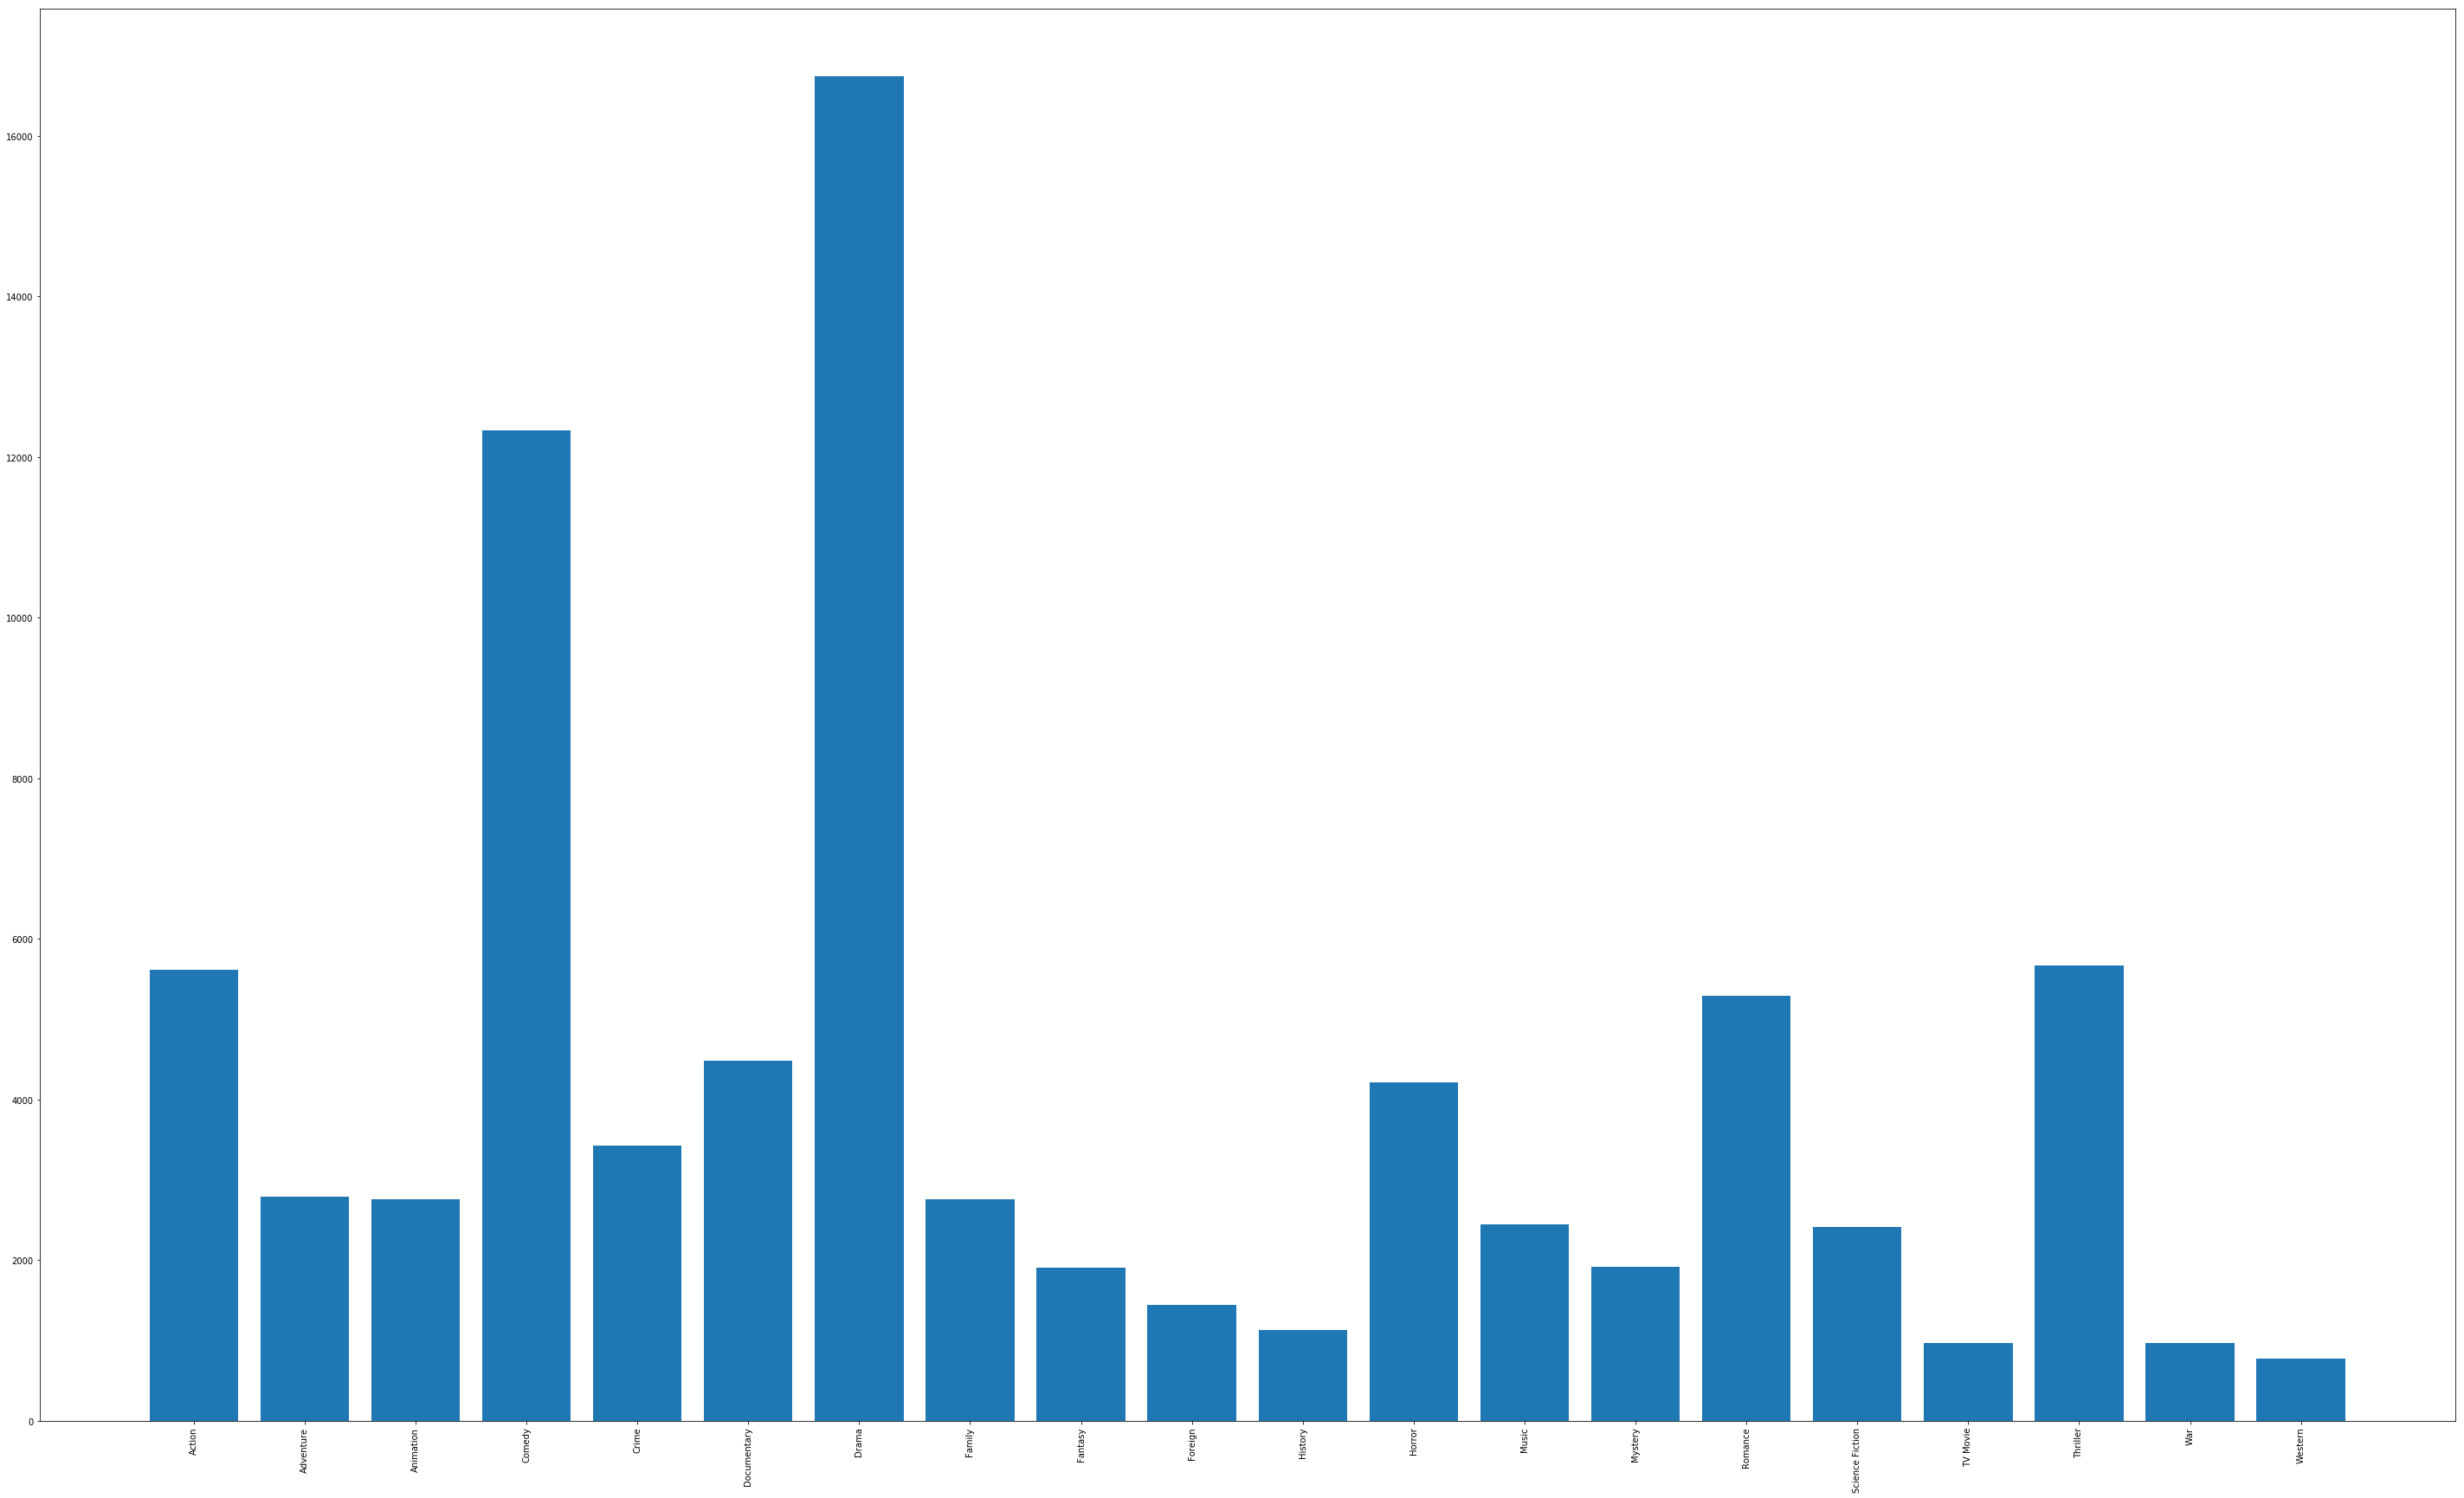

In [7]:
genres_dict={}
for index, row in test_data.iterrows():
    row_genres=ast.literal_eval(row['genres'])
    for genre in row_genres:
        if genre['name'] not in genres_dict:
            genres_dict[genre['name']]=0
        if(row['vote_count']==0):
            break
        genres_dict[genre['name']]= genres_dict[genre['name']]+1       

labels= genres_dict.keys()
data=genres_dict.values()

plt.figure( figsize=(50, 30))
plt.bar(labels, data)
plt.xticks(rotation=90)
plt.show()

# Genres of most popular movies

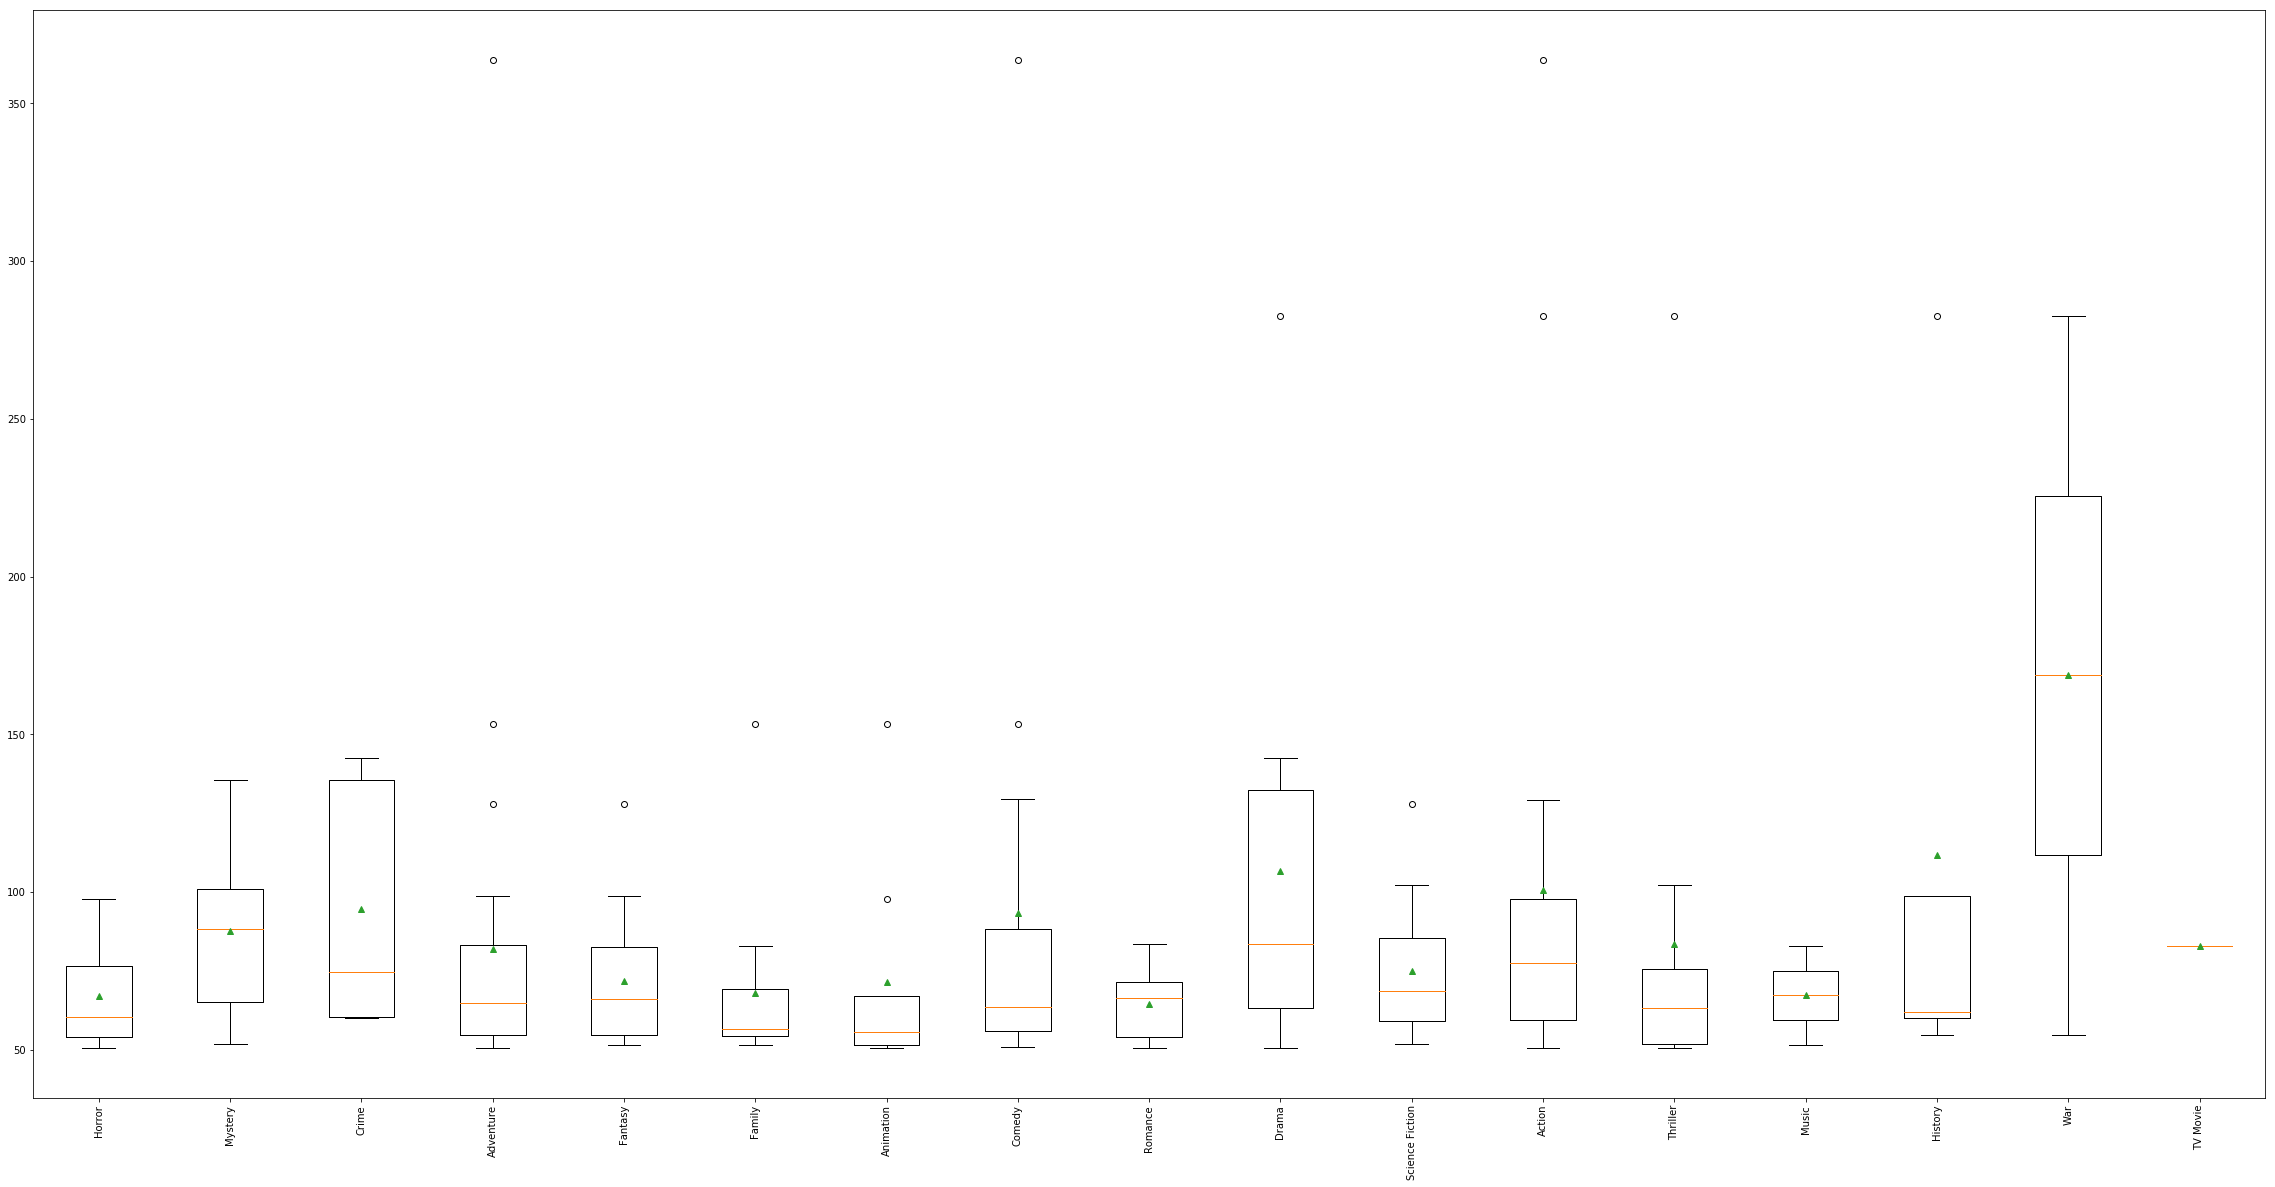

In [8]:
genres_dict={}
for index, row in test_data.iterrows():
    row_genres=ast.literal_eval(row['genres'])
    if(row['popularity']<=50):
        continue
    for genre in row_genres:
        if genre['name'] not in genres_dict:
            genres_dict[genre['name']]=[]
        genres_dict[genre['name']].append(row['popularity'])
    
labels= genres_dict.keys()
data=genres_dict.values()

plt.figure( figsize=(40, 20))
plt.boxplot(data,labels=labels,showmeans=True)
plt.xticks(rotation=90)
plt.show()

# Count the number of movies for companies

In [9]:
companies_dict={}
for index, row in test_data.iterrows():
    row_companies=ast.literal_eval(row['production_companies'])
    for company in row_companies:
        if company['name'] not in companies_dict:
            companies_dict[company['name']]=0
        companies_dict[company['name']]=companies_dict[company['name']]+1       


In [10]:
sorted_x = sorted(companies_dict.items(), key=operator.itemgetter(1),reverse=True)
print(sorted_x)

[('Warner Bros.', 847), ('Metro-Goldwyn-Mayer (MGM)', 737), ('Paramount Pictures', 680), ('Universal Pictures', 572), ('Twentieth Century Fox Film Corporation', 493), ('Columbia Pictures Corporation', 481), ('Columbia Pictures', 277), ('Canal+', 273), ('Walt Disney Productions', 267), ('BBC', 249), ('Shaw Brothers', 241), ('RKO Radio Pictures', 236), ('Walt Disney Pictures', 210), ('Mosfilm', 205), ('United Artists', 190), ('Evil Angel', 167), ('Zweites Deutsches Fernsehen (ZDF)', 153), ('Nikkatsu', 153), ('British Broadcasting Corporation (BBC)', 152), ('Toho Company', 146), ('New Line Cinema', 138), ('Digital Playground', 130), ('Republic Pictures', 128), ('Monogram Pictures', 125), ('Toei Company', 118), ("Children's Film Foundation (CFF)", 117), ('Nordisk Film', 115), ('World Wrestling Entertainment (WWE)', 115), ('DEFA', 114), ('Centre National de la Cinématographie (CNC)', 113), ('Walter Lantz Productions', 113), ('ZDF', 113), ('France 2 Cinéma', 112), ('Girlfriends Films', 108),

In [11]:
company_list=[]
for key, value in companies_dict.items():
    if (value>=50):
        company_list.append(key)

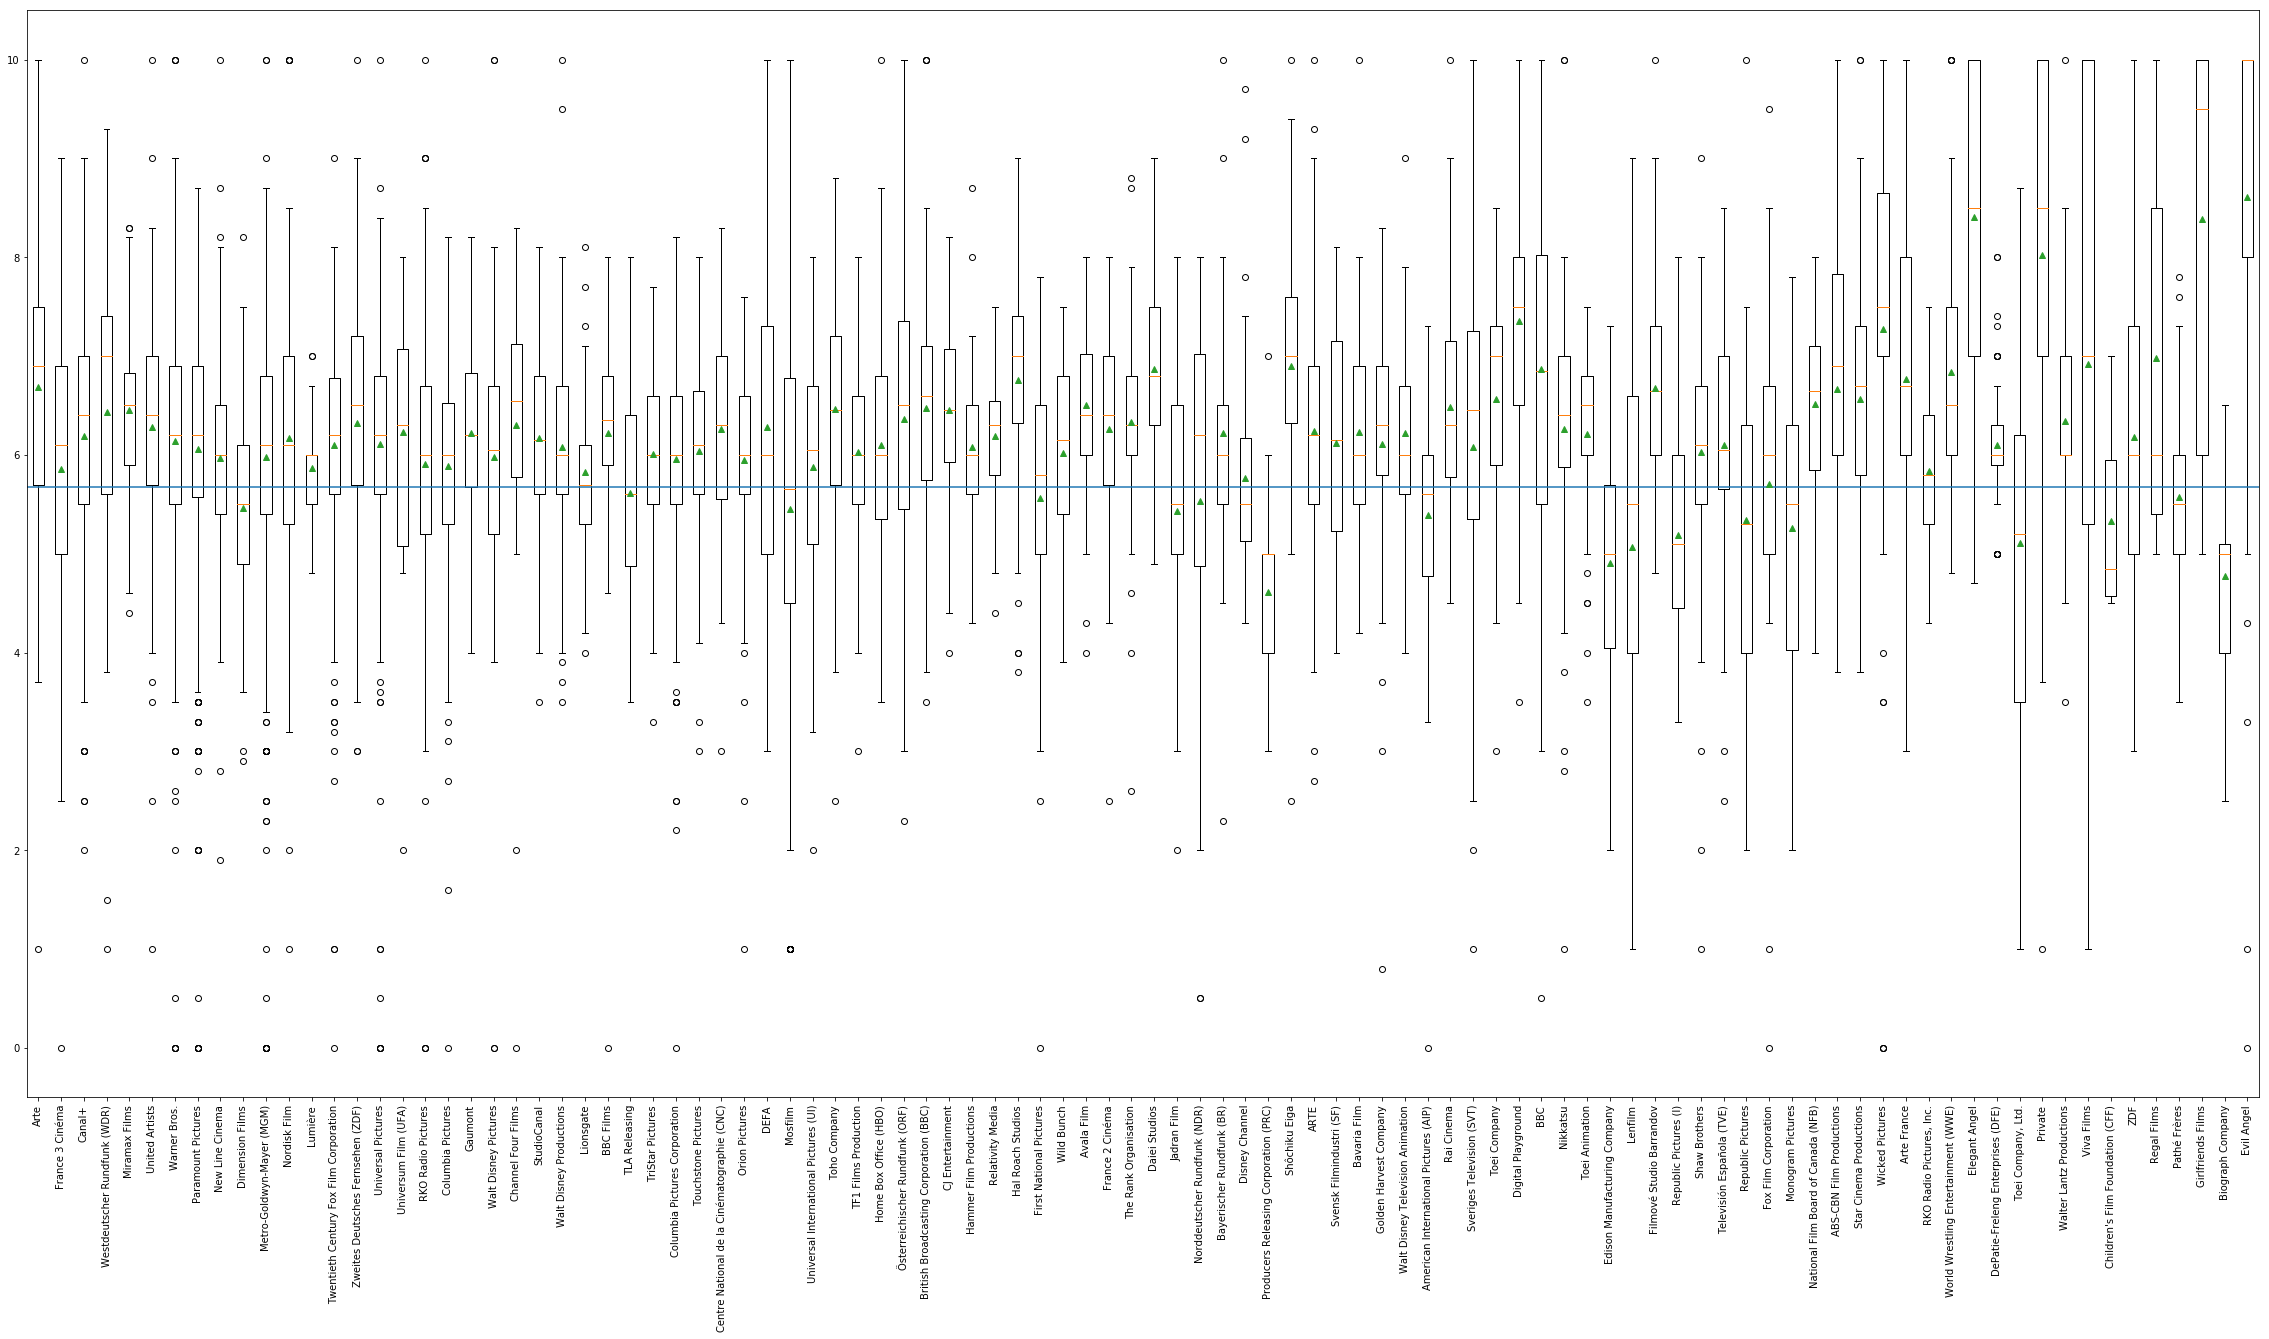

In [12]:
companies_dict={}
vote_sum=0
vote_count=0
for index, row in test_data.iterrows():
    row_companies=ast.literal_eval(row['production_companies'])
    if(row['vote_count']==0):
        continue
    for company in row_companies:
        if company['name'] not in company_list:
            continue
        if company['name'] not in companies_dict:
            companies_dict[company['name']]=[]
        companies_dict[company['name']].append(row['vote_average'])
    vote_sum=vote_sum+int(row['vote_average'])
    vote_count=vote_count+1
labels=companies_dict.keys()
data=companies_dict.values()

avg=vote_sum/vote_count

plt.figure( figsize=(40, 20))
plt.boxplot(data,labels=labels,showmeans=True)
plt.xticks(rotation=90)
plt.axhline(y=avg)
plt.show()

In [13]:
test_data.columns.values

array(['id', 'imdb_id', 'title', 'original_language', 'adult',
       'collection', 'runtime', 'popularity', 'vote_average',
       'vote_count', 'release_date', 'budget', 'revenue', 'release_dates',
       'genres', 'production_companies', 'production_countries', 'cast',
       'crew', 'keywords'], dtype=object)

In [24]:
corr_data=test_data[['adult','runtime','vote_average','vote_count','release_date','budget','revenue']].copy()
corr_data=corr_data[corr_data.vote_count!=0]
corr_data=corr_data[corr_data.budget!=0]
corr_data=corr_data[corr_data.revenue!=0]
corr_data['release_date']=corr_data['release_date'].str[:-6]
corr_data = corr_data.reset_index(drop=True)

In [15]:
#fucking positive only UNIX time in python
#corr_data['release_date'].apply(lambda x: print(datetime.datetime.strptime(x, "%Y-%m-%d").timestamp()))

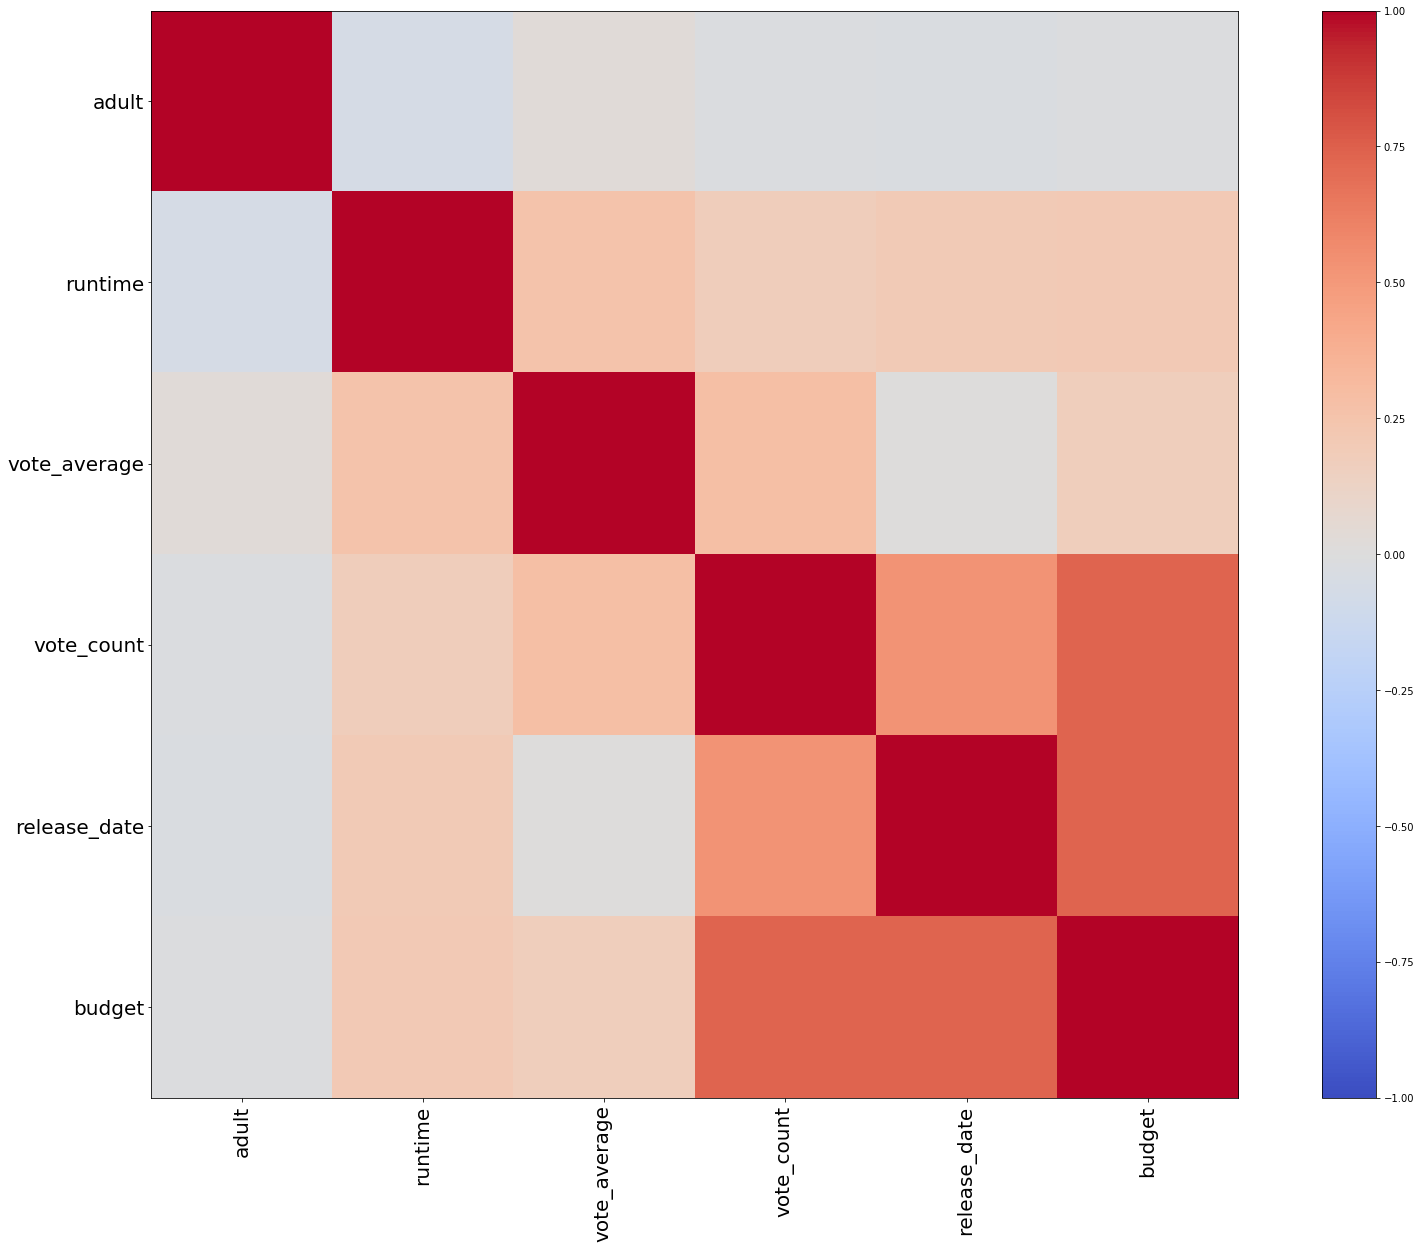

In [25]:
fig, ax = plt.subplots()
fig.set_figheight(20)
fig.set_figwidth(30)

image=ax.matshow(corr_data.corr(),interpolation='nearest', cmap=cm.coolwarm,vmin=-1, vmax=1)
colorbar=fig.colorbar(image)

labels=['adult','runtime','vote_average','vote_count','release_date','budget','revenue']

ax.set_xticklabels([''] + labels,fontsize=20)
ax.set_yticklabels([''] + labels,fontsize=20)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
od=plt.xticks(rotation='vertical')

In [17]:
budget_dict={}
for index, row in corr_data.iterrows():
    if int(row['budget']) < 1000:
        continue
    if row['budget'] not in budget_dict:
           budget_dict[row['budget']]=[0,0]
    budget_dict[row['budget']][1]=budget_dict[row['budget']][1]+1
    budget_dict[row['budget']][0]=budget_dict[row['budget']][0]+row['revenue']

In [48]:
#yolo
import warnings; warnings.simplefilter('ignore')
sorted_budget = sorted(budget_dict.items())
budget, abs_revenue = zip(*sorted_budget)
avg_revenue = [y[0]/y[1] for y in abs_revenue]

x_pred = np.linspace(budget[0], budget[-1], 100)
gp = GaussianProcess(theta0=1, thetaL=0.00001, thetaU=1000, nugget=0.000001)
gp.fit(np.atleast_2d(budget).T, avg_revenue)
y_pred = gp.predict(np.atleast_2d(x_pred).T)

#neviem ako vypisat tie hodnoty ako labels
# frequency=5
# plt.xticks(budget[::frequency], budget[::frequency])

plt.figure( figsize=(40, 20))
plt.xlabel('Budget')
plt.ylabel('Average revenue')
plt.plot(x_pred, y_pred, color='red')
plt.plot(budget, avg_revenue)
plt.show()

NameError: name 'budget_dict' is not defined

In [19]:
revenue_dict_vote={}
for index, row in corr_data.iterrows():
    if int(row['revenue']) < 1000:
        continue
    if row['revenue'] not in revenue_dict_vote:
           revenue_dict_vote[row['revenue']]=[0,0]
    revenue_dict_vote[row['revenue']][1]=revenue_dict_vote[row['revenue']][1]+1
    revenue_dict_vote[row['revenue']][0]=revenue_dict_vote[row['revenue']][0]+row['vote_average']

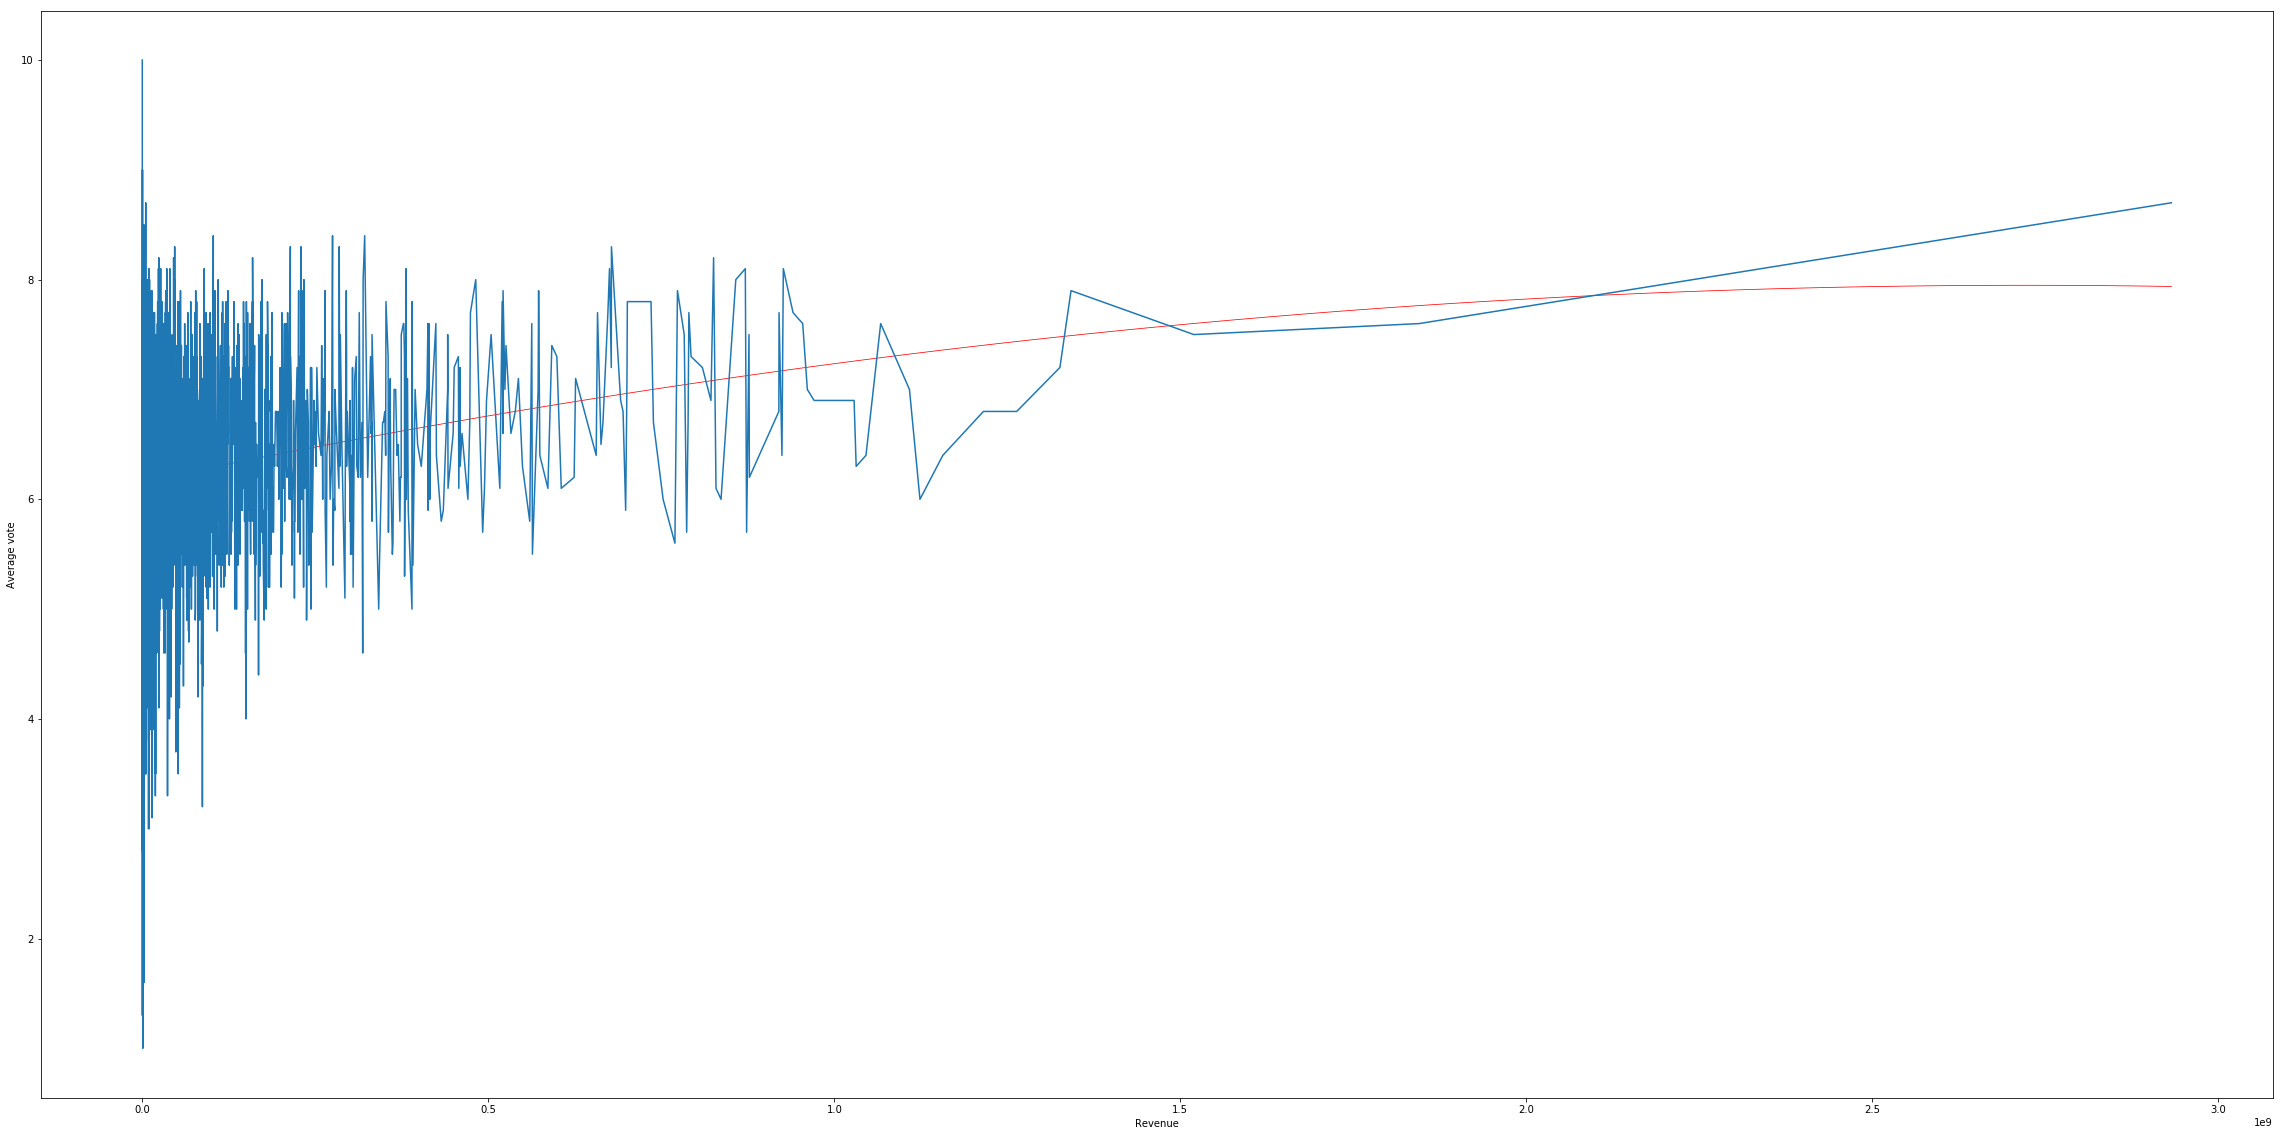

In [20]:
sorted_revenue_vote = sorted(revenue_dict_vote.items())
revenue, abs_vote = zip(*sorted_revenue_vote)
avg_vote = [y[0]/y[1] for y in abs_vote]

x_pred = np.linspace(revenue[0], revenue[-1], 100)
gp = GaussianProcess(theta0=1, thetaL=0.00001, thetaU=1000, nugget=0.000001)
gp.fit(np.atleast_2d(revenue).T, avg_vote)
y_pred = gp.predict(np.atleast_2d(x_pred).T)

plt.figure( figsize=(40, 20))
plt.xlabel('Revenue')
plt.ylabel('Average vote')
plt.plot(x_pred, y_pred, linestyle='-', linewidth=0.75, color='red')
plt.plot(revenue, avg_vote)
plt.show()

In [28]:
runtime_dict_vote={}
for index, row in corr_data.iterrows():
    if row['runtime'] == 0 or math.isnan(row['runtime']):
        continue
    if row['runtime'] not in runtime_dict_vote:
           runtime_dict_vote[row['runtime']]=[0,0]
    runtime_dict_vote[row['runtime']][1]=runtime_dict_vote[row['runtime']][1]+1
    runtime_dict_vote[row['runtime']][0]=runtime_dict_vote[row['runtime']][0]+row['vote_average']

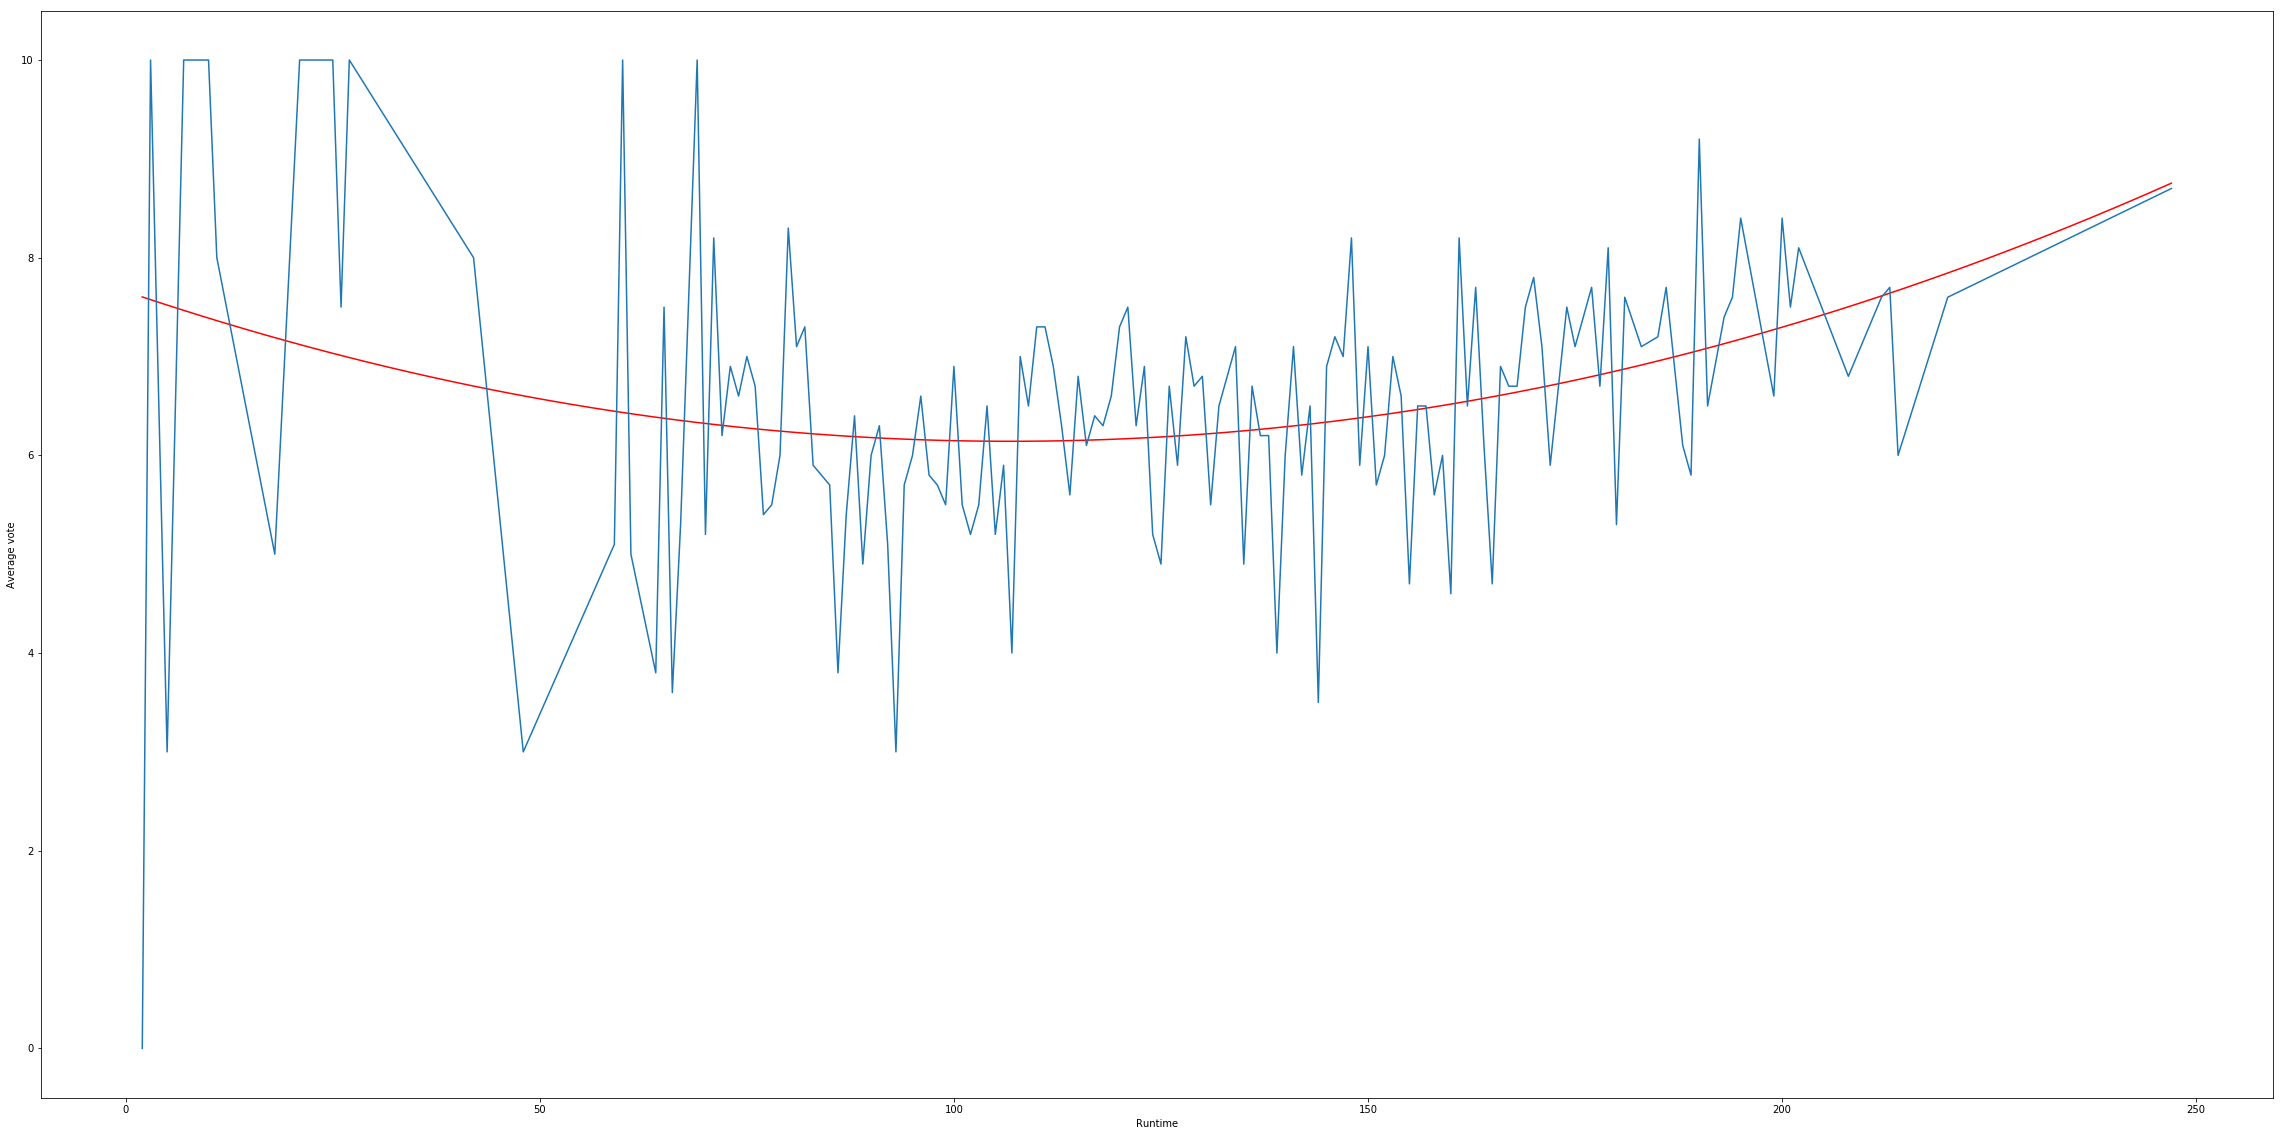

In [36]:
sorted_runtime_vote = sorted(runtime_dict_vote.items())
runtime, abs_vote = zip(*sorted_runtime_vote)
avg_vote = [y[0]/y[1] for y in abs_vote]

x_pred = np.linspace(runtime[0], runtime[-1], 100)
gp = GaussianProcess(theta0=1, thetaL=0.00001, thetaU=1000, nugget=0.000001)
gp.fit(np.atleast_2d(runtime).T, avg_vote)
y_pred = gp.predict(np.atleast_2d(x_pred).T)

plt.figure( figsize=(40, 20))
plt.xlabel('Runtime')
plt.ylabel('Average vote')
plt.plot(x_pred, y_pred, color='red')
plt.plot(runtime, avg_vote)
plt.show()

In [46]:
year_dict_vote={}
for index, row in corr_data.iterrows():
    if pd.isnull(row['release_date']):
        continue
    if int(row['release_date']) not in runtime_dict_vote:
           year_dict_vote[int(row['release_date'])]=[0,0]
    year_dict_vote[int(row['release_date'])][1]=year_dict_vote[int(row['release_date'])][1]+1
    year_dict_vote[int(row['release_date'])][0]=year_dict_vote[int(row['release_date'])][0]+row['vote_average']

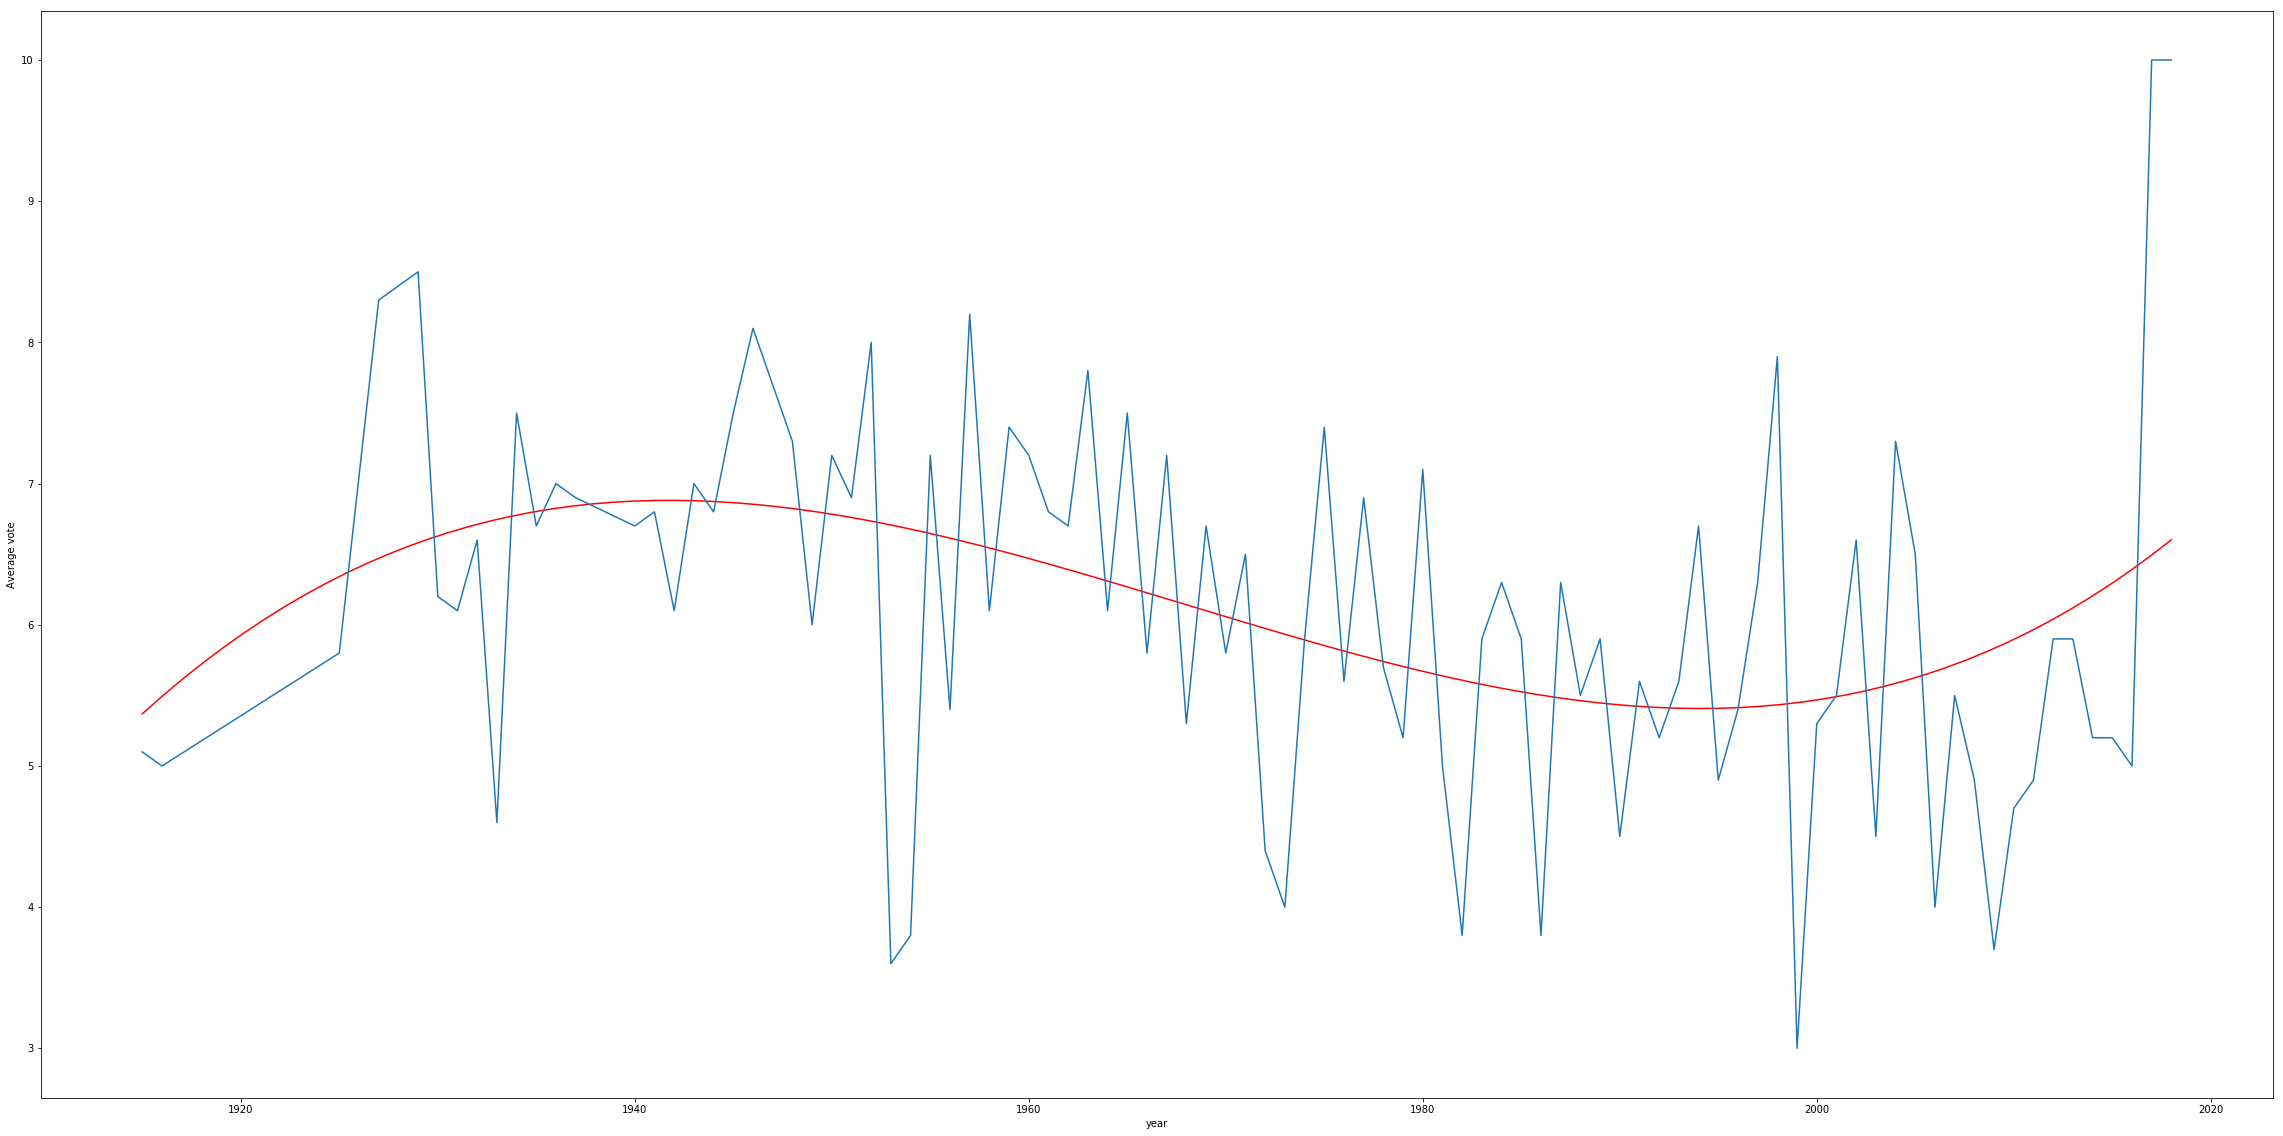

In [49]:
sorted_year_vote = sorted(year_dict_vote.items())
year, abs_vote = zip(*sorted_year_vote)
avg_vote = [y[0]/y[1] for y in abs_vote]

x_pred = np.linspace(year[0], year[-1], 100)
gp = GaussianProcess(theta0=1, thetaL=0.00001, thetaU=1000, nugget=0.000001)
gp.fit(np.atleast_2d(year).T, avg_vote)
y_pred = gp.predict(np.atleast_2d(x_pred).T)

plt.figure( figsize=(40, 20))
plt.xlabel('year')
plt.ylabel('Average vote')
plt.plot(x_pred, y_pred, color='red')
plt.plot(year, avg_vote)
plt.show()

In [50]:
keywords_dict={}
for index, row in test_data.iterrows():
    row_keywords=ast.literal_eval(row['keywords'])
    for keyword in row_keywords:
        if keyword['name'] not in keywords_dict:
            keywords_dict[keyword['name']]=0
        keywords_dict[keyword['name']]=keywords_dict[keyword['name']]+1       


In [53]:
sorted_k = sorted(keywords_dict.items(), key=operator.itemgetter(1),reverse=True)
print(sorted_k[:100])

[('woman director', 3849), ('short', 1730), ('independent film', 1427), ('murder', 1108), ('erotic movie', 968), ('musical', 897), ('sport', 839), ('sex', 826), ('silent film', 677), ('based on novel', 657), ('biography', 527), ('revenge', 482), ('love', 453), ('music', 452), ('suspense', 437), ('violence', 429), ('nudity', 399), ('philippines', 394), ('pinoy', 393), ('stand-up comedy', 387), ('world war ii', 383), ('parent child relationship', 366), ('martial arts', 366), ('concert', 363), ('teenager', 341), ('live concert', 327), ('drama', 323), ('police', 320), ('comedy', 311), ('documentary', 306), ('experimental', 304), ('friendship', 299), ('anal sex', 298), ('family', 297), ('sibling relationship', 286), ('christmas', 286), ('prison', 280), ('sequel', 277), ('drug', 275), ('lgbt', 264), ('serial killer', 260), ('rape', 255), ('romance', 241), ('kidnapping', 240), ('vampire', 237), ('gay', 236), ('zombie', 236), ('suicide', 233), ('female nudity', 230), ('wrestling', 227), ('lesb

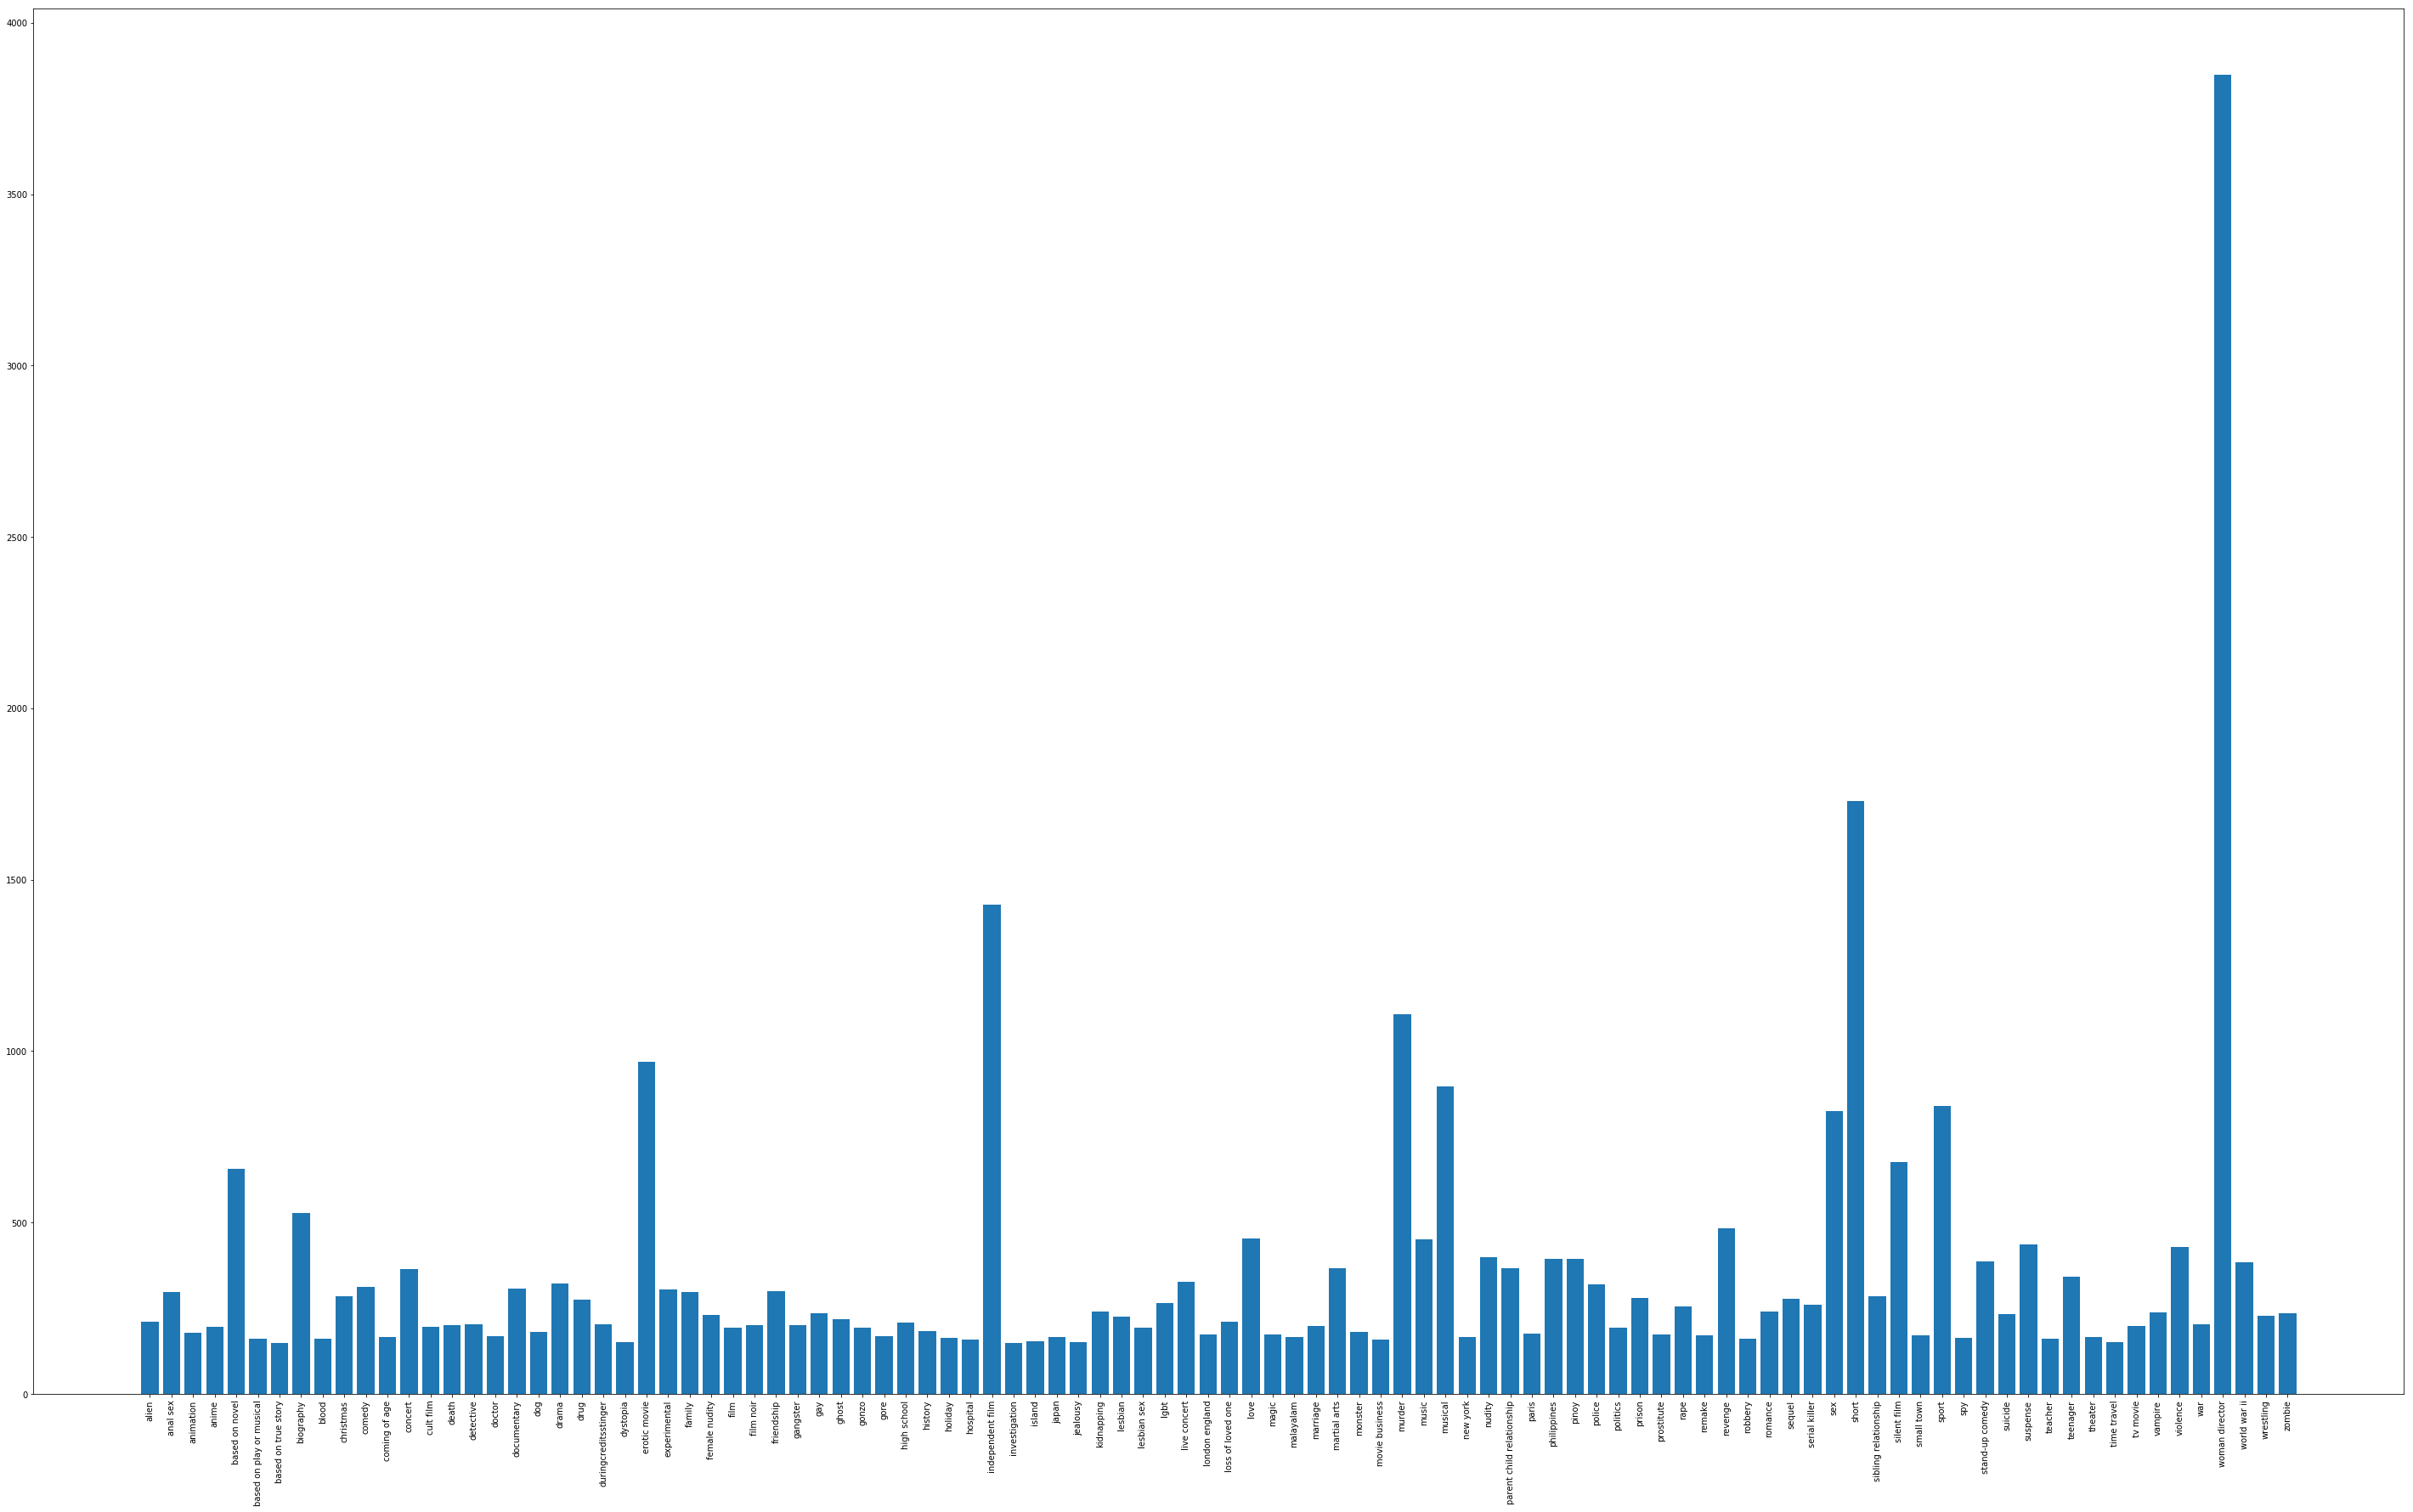

In [80]:
labels, data = zip(*sorted_k[:100])


plt.figure( figsize=(50, 30))
plt.bar(labels, data)
plt.xticks(rotation=90)
plt.show()